#Swing Model
Goal: Create a model to predict whether a batter will swing at a pitch

This notebook was created using Google Colaboratory.

Install and import packages

In [1]:
!pip install "fastai>=2"
!pip install geopandas
!pip install rfpimp

from fastai.tabular.all import *
import geopandas as gpd
import pandas as pd
from rfpimp import *
from shapely.geometry import box, Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


Read the training data set. Parse the date column as dates instead of strings.

In [2]:
df = pd.read_csv("/content/drive/My Drive/Data/2021-train.csv", parse_dates=["date"])
df.head()

,date,level,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,2019-04-30,MLB,5081ca93,Right,5bf361ca,Right,402559d3,4ff102e5,65ac286a,1,2,0.0,3,2,97.553703,-2.589460,-4.05425,2561.209961,217.522003,1:15,5.79008,2.03434,6.70482,-9.076600,19.322001,13.314900,2.59843,-0.543338,88.975403,-4.33686,-1.51515,-2.10376,55,5.84545,FA,InPlay,a89b9e68
1,2019-04-15,MLB,0bf5d3c5,Left,7c67a595,Left,d0d69f32,51a1c7ee,5e710b9e,7,2,2.0,0,0,87.313202,-1.179160,4.82753,2247.100098,177.750000,11:15,5.63548,-3.49087,5.20301,-30.060301,7.268020,-0.115828,1.99893,1.007350,81.046799,-6.67492,4.81739,3.44978,55,5.62918,FA,BallCalled,eaad389f
2,2019-05-26,MLB,0bf5d3c5,Left,de9d396f,Left,0c59f5af,3007964d,44924919,9,1,2.0,2,0,87.972099,-0.233382,4.33500,2248.639893,156.802994,11:00,5.50421,-3.81458,5.34483,-33.184399,3.828020,-1.352580,2.47228,0.225512,80.809196,-6.34958,4.08914,3.80582,55,5.50533,FA,InPlay,c8159d29
3,2019-05-27,MLB,af735dc4,Left,073c2b16,Right,a3f610ed,af66b76d,b05114c7,7,1,1.0,1,0,82.573303,0.451363,1.91461,1663.199951,161.953003,11:00,5.95604,-2.43185,6.50586,-37.207699,2.881010,0.073768,3.26562,-0.699844,75.435699,-6.59651,1.92897,2.49333,55,5.94996,SL,StrikeSwinging,e5cde642
4,2019-05-11,MLB,07d9667f,Right,4f03de7c,Right,402559d3,9d34b92a,016c0582,1,1,2.0,0,1,94.043198,-2.245080,-3.89307,2012.119995,190.309998,12:30,6.55957,2.53991,5.77950,-16.571501,15.050800,2.989490,3.01680,-0.848172,86.338600,-5.34015,-3.33303,-2.53086,55,6.57091,FA,StrikeSwinging,7c9410bd


### Data preprocessing


Add a feature for each batter's cumulative swing rate up through the day before a pitch.

In [3]:
# Calculate global mean for swing rate
mean_swing_rate = df.pitch_call.isin(["FoulBall", "InPlay", "StrikeSwinging"]).sum() / len(df.index)

# Calculate aggregated batter stats up to date
df_batter_stats = (
    df
    .assign(
        is_swing = lambda d: d.pitch_call.isin(["FoulBall", "InPlay", "StrikeSwinging"]).astype(int),
        n = True
    )
    .loc[:, ["date", "batter_id", "is_swing", "n"]]
    .groupby(["date", "batter_id", ])
    .sum()
    .unstack(["batter_id"])
    .cumsum()
    .fillna(method="ffill")
    .fillna(0)
)

df_swing_rates = (
    df_batter_stats
    .loc[:, "is_swing"].div(df_batter_stats.loc[:, "n"])
    .fillna(mean_swing_rate)
)

df_swing_rates

def get_swing_rate(row):
  # find swing rate up through previous day
  date = row.date - pd.Timedelta(days=1)

  if date in df_swing_rates.index:
    return df_swing_rates[row.batter_id][date]
  
  return mean_swing_rate

def get_swing_rate_test(row):
  # find swing rate up through training set (2019-06-30)
  return df_swing_rates[row.batter_id]["2019-06-30"]

Cleaning/preprocessing:
* Correcting `batter_side` and `pitcher_side` columns that are still set to `S`
* If using the `attack_zone` feature (see appendix), merging the `attack_zone` column
* If using the `balls_strikes` feature, create that column
* Cleaning the `tilt` column to have a consistent format
* Adding `*na` columns for features that have missing values
* Adding a `balls_strikes` column
* Adding the `is_swing` column
* Filling missing values
  * For `outs`, I just used `0` (since this is also the mode).
  * For `spin_rate`, I just used the median. There are probably better ways to fill the almost 18,000 missing spin rates, but because `spin_rate` doesn't seem to be that important of a feature, I just used the median.
  * For `tilt` I used the mode
  * For `plate_height` and `plate_side`, there really isn't a great to fill the data, so I used the median
  * Same for `pitch_type`, so I used the mode
* Now that we have filled missing values in the `outs` column, we can cast the column to `int`
* Correct cases where `outs` is set to `3`, balls is set to `4`, and strikes is set to `2`
* Cast categorical features as categories
* Replace the categorical features with their category codes. Note, `level`, `inning`, `outs`, `balls`, `strikes`, `tilt`, and `balls_strikes` are set as ordered categories.
* Drop unused columns
* Sort by date and reset the index

In [4]:
df.loc[(df.batter_side == "S") & (df.pitcher_side == "Right"), "batter_side"] = "Left"
df.loc[(df.batter_side == "S") & (df.pitcher_side == "Left"), "batter_side"] = "Right" 
df.loc[(df.pitcher_side == "S") & (df.batter_side == "Right"), "pitcher_side"] = "Left"
df.loc[(df.pitcher_side == "S") & (df.batter_side == "Left"), "pitcher_side"] = "Right"

df_clean = (
    df
    # .merge(df_attack_zone, how="left", on="pitch_id")
    .assign(
      tilt = lambda d: d.tilt.str.slice(stop=5).str.zfill(5),
      outs_na = df.outs.isna(), # 132
      spin_rate_na = df.spin_rate.isna(), # 17878
      tilt_na = df.tilt.isna(), # 664
      plate_height_na = df.plate_height.isna(), # 528
      plate_side_na = df.plate_side.isna(), # 528
      pitch_type_na = df.pitch_type.isna(), # 556
      swing_rate = lambda d: d.apply(get_swing_rate, axis=1),
      # is_2_strikes = df.strikes == 2,
      # is_3_balls = df.balls == 3,
      # balls_strikes = lambda d: d.balls.astype(str) + "_" + d.strikes.astype(str),
      is_swing = lambda d: d.pitch_call.isin(["FoulBall", "InPlay", "StrikeSwinging"]).astype(int)
    )
    .fillna({
        "outs": 0.0,
        "spin_rate": df.spin_rate.median(),
        "tilt": df.tilt.str.slice(stop=5).str.zfill(5).mode(),
        "plate_height": df.plate_height.median(),
        "plate_side": df.plate_side.median(),
        "pitch_type": df.pitch_type.mode()[0],
      })
    .astype({"outs": "int"})
    .replace({
        "outs": {
            3: 2
        },
        "balls": {
            4: 3
        },
        "strikes": {
            3: 2
        },
    },)
    .astype({
        "level": "category",
        # "pitcher_id": "category",
        "pitcher_side": "category",
        # "batter_id": "category",
        "batter_side": "category",
        # "stadium_id": "category",
        # "umpire_id": "category",
        # "catcher_id": "category",
        "inning": "category",
        "top_bottom": "category",
        "outs": "category",
        "balls": "category",
        "strikes": "category",
        "tilt": "category",
        "strikes": "category",
        "pitch_type": "category",
        # "is_2_strikes": "category",
        # "is_3_balls": "category",
        # "balls_strikes": "category",
        # "attack_zone": "category"
    })
    .assign(
      level = lambda d: d.level.cat.as_ordered().cat.codes + 1,
      # pitcher_id = lambda d: d.pitcher_id.cat.codes + 1,
      pitcher_side = lambda d: d.pitcher_side.cat.codes + 1,
      # batter_id = lambda d: d.batter_id.cat.codes + 1,
      batter_side = lambda d: d.batter_side.cat.codes + 1,
      # stadium_id = lambda d: d.stadium_id.cat.codes + 1,
      # umpire_id = lambda d: d.umpire_id.cat.codes + 1,
      # catcher_id = lambda d: d.catcher_id.cat.codes + 1,
      inning = lambda d: d.inning.cat.as_ordered().cat.codes + 1,
      top_bottom = lambda d: d.top_bottom.cat.codes + 1,
      outs = lambda d: d.outs.cat.as_ordered().cat.codes + 1,
      balls = lambda d: d.balls.cat.as_ordered().cat.codes + 1,
      strikes = lambda d: d.strikes.cat.as_ordered().cat.codes + 1,
      tilt = lambda d: d.tilt.cat.as_ordered().cat.codes + 1,
      pitch_type = lambda d: d.pitch_type.cat.codes + 1,
      # # is_2_strikes = lambda d: d.is_2_strikes.cat.codes + 1,
      # is_3_balls = lambda d: d.is_3_balls.cat.codes + 1
      # balls_strikes = lambda d: d.balls_strikes.cat.as_ordered().cat.codes + 1,
      # attack_zone = lambda d: d.attack_zone.cat.codes + 1
    )
    .drop([
          #  "geometry",
           "pitcher_id",
           "batter_id",
           "stadium_id",
           "umpire_id",
           "catcher_id",
           "y55", # because it is always 55
           "pitch_call", # because it leaks is_swing
    ], axis=1)
    .set_index("pitch_id", drop=True)
    .sort_values(by=["date"])
    
)

df_clean.head()

,date,level,pitcher_side,batter_side,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,x55,z55,pitch_type,outs_na,spin_rate_na,tilt_na,plate_height_na,plate_side_na,pitch_type_na,swing_rate,is_swing
pitch_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
be3ea65b,2019-04-01,5,2,2,5,1,3,2,1,92.886398,-3.562100,-4.72820,2095.030029,225.175003,3,5.96349,2.61011,6.16204,-16.183300,16.235600,16.280100,1.222480,-0.466732,84.457100,-6.62085,-1.657360,-2.65277,5.99241,3,False,False,False,False,False,False,0.466533,0
45238756,2019-04-01,5,1,2,6,2,3,1,2,91.792999,-3.443300,5.61971,2329.300049,151.895996,41,5.92059,-2.98475,6.50908,-13.235100,18.749599,-9.614690,1.650330,1.337680,84.677101,-5.95787,3.809970,3.08316,5.97426,3,False,False,False,False,False,False,0.466533,0
1ffa2b74,2019-04-01,5,1,2,4,1,2,1,1,82.778503,-2.999260,3.08055,1845.660034,117.689003,38,6.24060,-1.90236,5.17834,-33.075600,9.334590,-17.080099,0.564341,-0.381738,75.700104,-9.07439,-0.083938,1.87295,6.22258,1,False,False,False,False,False,False,0.466533,0
96309e70,2019-04-01,5,2,2,1,2,1,3,3,90.905296,-2.613000,-3.36566,2019.540039,231.776993,3,5.90216,1.71563,6.22396,-22.084299,11.430200,13.569800,1.568290,-0.319324,83.029099,-6.78134,-0.797740,-1.73808,5.94149,5,False,False,False,False,False,False,0.466533,1
d28f1e47,2019-04-01,5,2,2,8,1,3,2,2,83.503304,0.039169,-3.02626,2379.159912,69.765198,24,5.89110,2.87506,5.69826,-41.401901,-0.722012,-1.819660,2.399770,-0.146827,76.312897,-7.68589,-3.364060,-2.87967,5.88908,6,False,False,False,False,False,False,0.466533,1


In [5]:
xs_train, xs_valid, y_train, y_valid = train_test_split(df_clean.drop(["date", "is_swing"], axis=1), df_clean.is_swing, shuffle=False)

###Baseline
Create a baseline where we always predict `is_swing` is 0 (a take). This leads to 52.7% accuracy and an ROC of 0.5.

In [6]:
# All Take 
y_pred_take = np.zeros_like(y_valid)
print(round(accuracy_score(y_valid, y_pred_take), 3), round(roc_auc_score(y_valid, y_pred_take), 3))

0.527 0.5


###Decision Tree
Try a decision tree. This leads to 76.5% accuracy and an ROC of 76.3%.

In [7]:
dt = DecisionTreeClassifier(min_samples_leaf=500)
dt.fit(xs_train, y_train)
y_pred_dt = dt.predict(xs_valid)
print(round(accuracy_score(y_valid, y_pred_dt), 3), round(roc_auc_score(y_valid, y_pred_dt), 3))

0.765 0.763


Check the number of leaves to make sure we're not overfitting. `1251` seems reasonable.

In [8]:
dt.get_n_leaves()

1251

###Random Forest
Try a Random Forest. This leads to an accuracy of 76.7% and an ROC of 76.5% when using n_estimators=100. I used the below model to inform feature engineering (fewer estimators and sampling).

In [9]:
rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=500, n_jobs=-1, max_samples=200000)
rf.fit(xs_train, y_train)
y_pred_rf = rf.predict(xs_valid)
print(round(accuracy_score(y_valid, y_pred_rf), 3), round(roc_auc_score(y_valid, y_pred_rf), 3))

0.758 0.756


##Final Model
Train a random forest on all of the training data.

In [11]:
xs_train_all = df_clean.drop(["date", "is_swing"], axis=1)
y_train_all = df_clean.is_swing

rf_all = RandomForestClassifier(min_samples_leaf=500, n_jobs=-1)
rf_all.fit(xs_train_all, y_train_all)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Load the test dataset and prepare it in a similar way to the training dataset.

In [26]:
df_test = pd.read_csv("/content/drive/My Drive/Data/2021-test.csv", parse_dates=["date"])
df_test.head()

df_test.loc[(df_test.batter_side == "S") & (df_test.pitcher_side == "Right"), "batter_side"] = "Left"
df_test.loc[(df_test.batter_side == "S") & (df_test.pitcher_side == "Left"), "batter_side"] = "Right" 
df_test.loc[(df_test.pitcher_side == "S") & (df_test.batter_side == "Right"), "pitcher_side"] = "Left"
df_test.loc[(df_test.pitcher_side == "S") & (df_test.batter_side == "Left"), "pitcher_side"] = "Right"

df_test_clean = (
    df_test
    .assign(
      tilt = lambda d: d.tilt.str.slice(stop=5).str.zfill(5),
      outs_na = df_test.outs.isna(), # 132
      spin_rate_na = df_test.spin_rate.isna(), # 17878
      tilt_na = df_test.tilt.isna(), # 664
      plate_height_na = df_test.plate_height.isna(), # 528
      plate_side_na = df_test.plate_side.isna(), # 528
      pitch_type_na = df_test.pitch_type.isna(), # 556
      swing_rate = lambda d: d.apply(get_swing_rate_test, axis=1),
    )
    .fillna({
        "outs": 0.0,
        "spin_rate": df.spin_rate.median(), # fill with medians/modes from training data
        "tilt": df.tilt.str.slice(stop=5).str.zfill(5).mode(),
        "plate_height": df.plate_height.median(),
        "plate_side": df.plate_side.median(),
        "pitch_type": df.pitch_type.mode()[0],
      })
    .astype({"outs": "int"})
    .replace({
        "outs": {
            3: 2
        },
        "balls": {
            4: 3
        },
        "strikes": {
            3: 2
        },
    },)
    .astype({
        "level": "category",
        "pitcher_side": "category",
        "batter_side": "category",
        "inning": "category",
        "top_bottom": "category",
        "outs": "category",
        "balls": "category",
        "strikes": "category",
        "tilt": "category",
        "strikes": "category",
        "pitch_type": "category",
    })
    .assign(
      level = lambda d: d.level.cat.as_ordered().cat.codes + 1,
      pitcher_side = lambda d: d.pitcher_side.cat.codes + 1,
      batter_side = lambda d: d.batter_side.cat.codes + 1,
      inning = lambda d: d.inning.cat.as_ordered().cat.codes + 1,
      top_bottom = lambda d: d.top_bottom.cat.codes + 1,
      outs = lambda d: d.outs.cat.as_ordered().cat.codes + 1,
      balls = lambda d: d.balls.cat.as_ordered().cat.codes + 1,
      strikes = lambda d: d.strikes.cat.as_ordered().cat.codes + 1,
      tilt = lambda d: d.tilt.cat.as_ordered().cat.codes + 1, # checked that train and test sets will have same tilt codes
      pitch_type = lambda d: d.pitch_type.cat.codes + 1,
    )
    .drop([
           "pitcher_id",
           "batter_id",
           "stadium_id",
           "umpire_id",
           "catcher_id",
           "y55", # because it is always 55
    ], axis=1)
    .set_index("pitch_id", drop=True)
    .sort_values(by=["date"])
)

df_test_clean.head()

,date,level,pitcher_side,batter_side,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,x55,z55,pitch_type,is_swing,outs_na,spin_rate_na,tilt_na,plate_height_na,plate_side_na,pitch_type_na,swing_rate
pitch_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ab79d2c8,2019-07-01,3,2,2,8,1,3,1,2,93.887497,-3.33861,-0.360953,2669.709961,182.028000,45,6.89382,0.581809,5.80669,-6.834430,25.7145,1.05958,3.21194,0.331410,84.480598,-4.62379,-0.157365,-0.520899,6.94446,3,NaN,False,False,False,False,False,False,0.516432
dfabe02b,2019-07-01,2,2,2,8,2,2,2,1,87.508102,-0.93260,-2.837120,2293.510010,236.503998,4,5.21215,1.620090,6.22065,-26.548500,9.9990,19.41630,2.18859,0.488852,78.698097,-5.97568,0.878822,-1.661480,5.23396,3,NaN,False,False,False,False,False,False,0.423762
0518c99e,2019-07-01,2,1,2,1,1,2,2,1,75.816902,1.95854,-0.856592,2506.919922,303.471008,14,5.70394,-2.098060,5.40823,-60.761002,-10.3797,16.31180,2.49590,-1.580890,68.792801,-9.35805,2.202660,2.026590,5.68593,2,NaN,False,False,False,False,False,False,0.635815
c8498cee,2019-07-01,2,2,2,8,1,2,4,1,92.542099,-2.77538,-0.901670,2296.750000,226.065002,3,6.08346,-0.009994,5.98979,-20.280001,12.7007,13.81800,1.91900,0.271214,84.126099,-6.57250,1.713730,0.005938,6.14081,3,NaN,False,False,False,False,False,False,0.374912
5a89fe15,2019-07-01,4,1,2,3,1,3,3,3,93.624603,-2.63387,1.139470,2378.020020,159.238998,42,5.81772,-1.306730,6.55919,-14.035700,17.1369,-6.65121,2.30117,-0.801046,85.640701,-5.29341,-0.124006,1.375710,5.88248,3,NaN,False,False,False,False,False,False,0.367876


Predict `is_swing` for the test dataset and export a csv with the pitch ids and the predicted `is_swing`

In [27]:
y_pred_test = rf_all.predict(df_test_clean.drop(["date", "is_swing"], axis=1))

In [31]:
is_swing_test = pd.DataFrame(y_pred_test, index=df_test_clean.index).rename({0: "is_swing"}, axis=1)
is_swing_test

,is_swing
pitch_id,
ab79d2c8,1
dfabe02b,1
0518c99e,0
c8498cee,0
5a89fe15,1
...,...
1e7e7e66,0
b4cea704,0
7b93a2e5,1


In [32]:
is_swing_test.to_csv("IsaacLee_is_swing_test.csv")

## Additional code blocks
I used the following blocks to guide data cleaning and feature engineering. I also created some features and tried some models that didn't help too much or work too well.

### Utilities for investigating features and models

Investigate the important features. It seems like the most important features are the location of the pitch (`plate_side` and `plate_height`), and the number of `strikes`.

Also important are the movement of the pitch (`horz_break` and `vert_break`), the vertical release angle, and the number of `balls`.



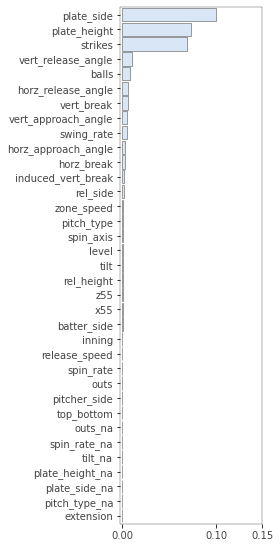

In [14]:
imp = importances(rf, xs_valid, y_valid, n_samples=-1)
viz = plot_importances(imp)
viz.view()

Investigate the features. `vert_break` and `induced_vert_break` are highly correlated. 

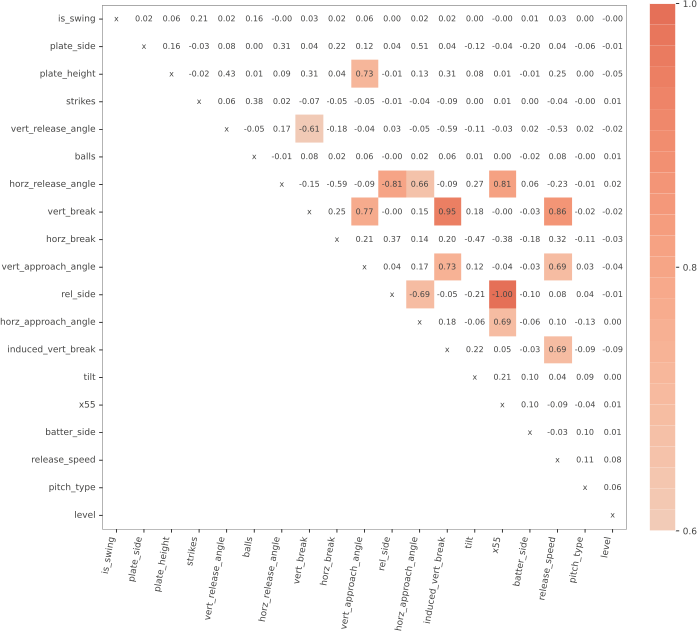

In [15]:
cols = [
        "is_swing",
        "plate_side",
        "plate_height",
        "strikes",
        "vert_release_angle",
        "balls",
        "horz_release_angle",
        "vert_break",
        "horz_break",
        "vert_approach_angle",
        "rel_side",
        "horz_approach_angle",
        "induced_vert_break",
        "tilt",
        "x55",
        "batter_side",
        "release_speed",
        "pitch_type",
        "level",
]
plot_corr_heatmap(df_clean[cols], figsize=(10,10))

Use cross validation to select a good value for `min_samples_leaf` for a decision tree. `500` seems work pretty well.

In [16]:
# Decision Tree CV
# param_grid = [
#               {"min_samples_leaf": [100, 250, 500, 750, 1000]}
# ]

# dt = GridSearchCV(DecisionTreeClassifier(), param_grid)
# dt.fit(xs_train, y_train)
# print("Best parameters set found on development set:")
# print(dt.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = dt.cv_results_['mean_test_score']
# stds = dt.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, dt.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))

This chart helps find an adequate `n_estimators` parameter for random forests.

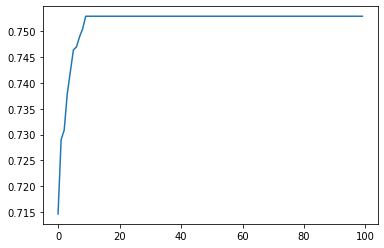

In [17]:
preds = np.stack([e.predict(xs_valid) for e in rf.estimators_])
plt.plot([roc_auc_score(preds[:i+1].mean(0).round(), y_valid) for i in range(100)]);

### Other features that I tried

Created an attack zones feature (from http://tangotiger.net/strikezone/attack-zone_legend.png and http://tangotiger.net/strikezone/zone%20.0chart.png). This greatly improved logistic regression, but not the decision tree or random forest models.

In [18]:
attack_zones = gpd.GeoSeries(
    {
      # heart
      1: box(-6.7/12.0, 34.0/12.0, -3.3/12.0, 38.0/12.0),
      2: box(-3.3/12.0, 34.0/12.0, 3.3/12.0, 38.0/12.0),
      3: box(3.3/12.0, 34.0/12.0, 6.7/12.0, 38.0/12.0),
      4: box(-6.7/12.0, 26.0/12.0, -3.3/12.0, 34.0/12.0),
      5: box(-3.3/12.0, 26.0/12.0, 3.3/12.0, 34.0/12.0),
      6: box(3.3/12.0, 26.0/12.0, 6.7/12.0, 34.0/12.0),
      7: box(-6.7/12.0, 22.0/12.0, -3.3/12.0, 26.0/12.0),
      8: box(-3.3/12.0, 22.0/12.0, 3.3/12.0, 26.0/12.0),
      9: box(3.3/12.0, 22.0/12.0, 6.7/12.0, 26.0/12.0),
      #  shadow
      11: box(-13.3/12.0, 38.0/12.0, -6.7/12.0, 46.0/12.0),
      12: box(-6.7/12.0, 38.0/12.0, 6.7/12.0, 46.0/12.0),
      13: box(6.7/12.0, 38.0/12.0, 13.3/12.0, 46.0/12.0),
      14: box(-13.3/12.0, 22.0/12.0, -6.7/12.0, 38.0/12.0),
      16: box(6.7/12.0, 22.0/12.0, 13/12.0, 38.0/12.0),
      17: box(-13.3/12.0, 14.0/12.0, -6.7/12.0, 22.0/12.0),
      18: box(-6.7/12.0, 14.0/12.0, 6.7/12.0, 22.0/12.0),
      19: box(6.7/12.0, 14.0/12.0, 13.3/12.0, 22.0/12.0),
      # chase
      21: box(-20.0/12.0, 38.0/12.0, -6.7/12.0, 60/12.0),
      22: box(-6.7/12.0, 46.0/12.0, 6.7/12.0, 60/12.0),
      23: box(6.7/12.0, 48/12.0, 20.0/12.0, 60/12.0),
      24: box(-20.0/12.0, 22.0/12.0, -13.3/12.0, 38.0/12.0),
      26: box(13.3/12.0, 22.0/12.0, 20.0/12.0, 38.0/12.0),
      27: box(-20.0/12.0, 0/12.0, -6.7/12.0, 22.0/12.0),
      28: box(-6.7/12.0, 0/12.0, 6.7/12.0, 14.0/12.0),
      29: box(6.7/12.0, 0/12.0, 20.0/12.0, 22.0/12.0)
    }
)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.plate_side, df.plate_height))

gdf_attack_zone = (
    gdf
    .assign(**{f"{key}": gdf.geometry.within(zone) for key, zone in attack_zones.items()})
    .assign(**{"30": True}) # default attack_zone aka waste region
    .filter(items=["pitch_id"] + [str(i) for i in attack_zones.keys().tolist()] + ["30"])
    .set_index("pitch_id")
    .stack()
    .reset_index()
    .rename(columns={
        "level_1": "attack_zone",
        0: "value"
      })
    .query("value")
    .drop(["value"], axis=1)
    .drop_duplicates(subset="pitch_id")
    .astype({"attack_zone": "int"})
    .reset_index(drop=True)
)

df_attack_zone = pd.DataFrame(gdf_attack_zone)
df_attack_zone

,pitch_id,attack_zone
0,a89b9e68,4
1,eaad389f,16
2,c8159d29,5
3,e5cde642,11
4,7c9410bd,14
...,...,...
1097721,4c4be361,22
1097722,127d2f94,30
1097723,d5e4c4ce,27
1097724,e97fa8c8,28


###Other models that I tried

Try a boosted tree using XGBoost. This leads to an accuracy of 73.9% and an roc_auc_score of 74.5%.

In [10]:
params = {
    "objective": "binary:hinge"
}

dtrain = xgb.DMatrix(xs_train, label=y_train)
bst = xgb.train(params, dtrain)
dvalid = xgb.DMatrix(xs_valid)
y_pred_bst = bst.predict(dvalid)
print(round(accuracy_score(y_valid, y_pred_bst), 3), round(roc_auc_score(y_valid, y_pred_bst), 3))

0.739 0.745


Try logistic regression. This leads to 69.6% accuracy and an ROC of 69.4% when the `attack_zones` and `balls_strikes` features are used. The below model does not include those features. 

In [19]:
# Logistic Regression
reg = LogisticRegression()
reg.fit(xs_train, y_train)
y_pred = reg.predict(xs_valid)
print(accuracy_score(y_valid, y_pred))
print(roc_auc_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5927187791511194
0.5867213669577174
              precision    recall  f1-score   support

           0       0.60      0.70      0.64    144639
           1       0.59      0.48      0.52    129793

    accuracy                           0.59    274432
   macro avg       0.59      0.59      0.58    274432
weighted avg       0.59      0.59      0.59    274432

[[100898  43741]
 [ 68030  61763]]


Try a neural network. This uses the FastAI library.

In [20]:
# Neural Network
cont_nn, cat_nn = cont_cat_split(df_clean, max_card=5000, dep_var="is_swing")
splits = (list(range(0, len(xs_train))), list(range(len(xs_train) + 1, len(df_clean))))
to_nn = TabularPandas(df_clean, [Categorify, Normalize], cat_nn, cont_nn, y_names="is_swing", y_block=CategoryBlock(), splits=splits)
learn = tabular_learner(to_nn.dataloaders(1024), y_range=(0, 1), loss_func=CrossEntropyLossFlat(), metrics=RocAucBinary())
# learn.lr_find()
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.635334,0.646384,0.673025,00:51
1,0.696966,0.714821,0.567567,00:54
2,0.778117,0.786200,0.500000,00:51
3,0.780566,0.786200,0.500000,00:52
4,0.777397,0.786200,0.500000,00:56
